In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR
from datasets import inputs

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
factor = 5
dataset = inputs.Sim1DFeederAndCache(
    steps_in_phases=[0,6000,0],
    left_right_stay_prob=[2,1,1], expansion=1,
    num_spatial_states=16*factor,
    visit_length=1,
    feeder_states = np.arange(8*factor, 9*factor)
    )

# Sanity Check Plots

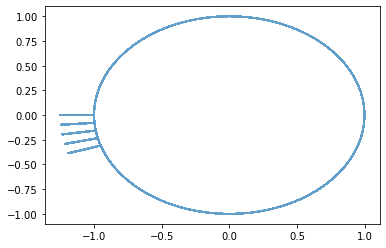

In [17]:
plt.figure();
plt.plot(dataset.xs, dataset.ys, alpha=0.7)
plt.show()

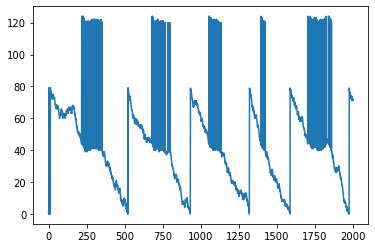

In [18]:
plt.figure();
plt.plot(dataset.state_inputs[:2000])
plt.show()

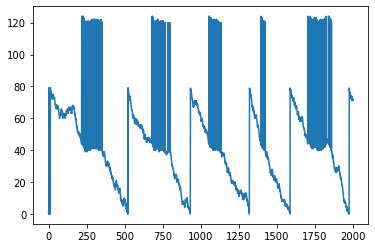

In [19]:
plt.figure();
plt.plot(dataset.expanded_state_inputs[:2000])
plt.show()

# Run through model

In [20]:
def get_M(T, gamma):
    return np.linalg.pinv(np.eye(T.shape[0]) - gamma*T)
    
def normalize(T):
    row_sums = np.sum(T, axis=1)
    unvisited_states = (row_sums == 0)
    T = T/row_sums[:, np.newaxis]
    T[unvisited_states] = 0
    return T

In [21]:
outputs = []
gamma = 0.9
T_counts = np.zeros((dataset.num_expanded_states, dataset.num_expanded_states))
for step in np.arange(1, dataset.num_steps):
    prev_state = dataset.expanded_state_inputs[step-1]
    curr_state = dataset.expanded_state_inputs[step]
    T_counts[prev_state, curr_state] +=1

# Static M

In [73]:
gamma = 0.97
plot_feeder_cells = True

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_44743/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


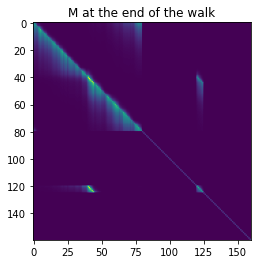

In [74]:
M = get_M(normalize(T_counts), gamma)
plt.figure()
plt.imshow(M)
plt.title('M at the end of the walk')
plt.show()

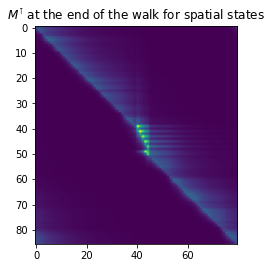

In [75]:
if plot_feeder_cells:
    feeder_states = np.concatenate([
        np.arange(f*dataset.expansion, (f+1)*dataset.expansion) for f in dataset.feeder_states
        ]) + (dataset.num_spatial_states*dataset.expansion)
    interleaved_feeder_states = list(chain(*zip(dataset.feeder_states, feeder_states)))
    feeder_states = interleaved_feeder_states
else:
    feeder_states = dataset.feeder_states
pre_feeder_state = (dataset.feeder_states[0])*dataset.expansion - 1
post_feeder_state = (dataset.feeder_states[-1])*dataset.expansion - 1

# Drop unused non-spatial columns
M = M[:, np.concatenate((
    np.arange(pre_feeder_state),
    feeder_states,
    np.arange(post_feeder_state, dataset.num_spatial_states)
    ))]

# Sum matrix across aliased spatial states
_aliased_M = M[:dataset.num_spatial_states*dataset.expansion]
_aliased_M += M[dataset.num_spatial_states*dataset.expansion:]

# Squash expansion if necessary
if dataset.expansion > 1:
    aliased_M = np.zeros((dataset.num_spatial_states, _aliased_M.shape[1]))
    for i in range(dataset.num_spatial_states):
        for j in range(_aliased_M.shape[1]):
            aliased_M[i,j] = np.mean(
                _aliased_M[np.arange(i*dataset.expansion, (i+1)*dataset.expansion), j]
                )
else:
    aliased_M = _aliased_M

plt.figure()
plt.imshow(aliased_M.T)
plt.title('$M^\intercal$ at the end of the walk for spatial states')
plt.show()

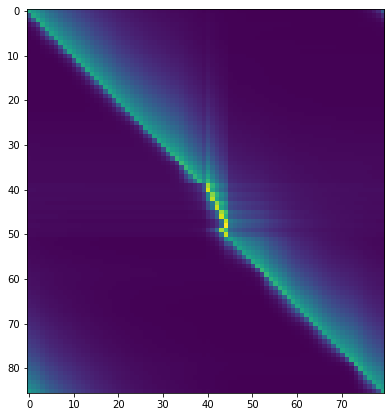

In [76]:
def z_score(M):
    """ Z-Scores by COLUMNS """
    M = M.copy()
    M -= np.mean(M, axis=0)[np.newaxis,:]
    M /= np.std(M, axis=0)[np.newaxis,:]
    return M
    
plt.figure(figsize=(6.4*1, 4.8*2))
norm_aliased_M = z_score(aliased_M)
plt.imshow(norm_aliased_M.T)
plt.show()

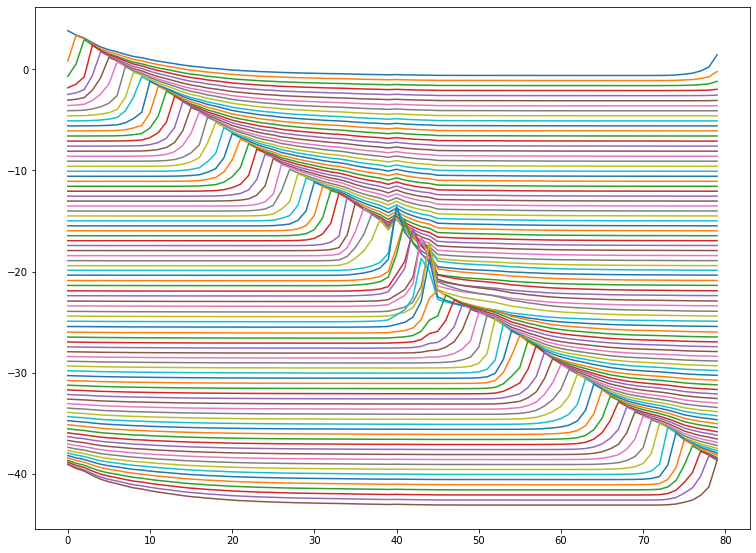

In [77]:
plt_idx = 0
plt_step = -0.5 #-1.
plt.figure(figsize=(6.4*2, 4.8*2))
for ff in norm_aliased_M.T:
    plt.plot(ff + plt_idx)
    plt_idx += plt_step
plt.show()

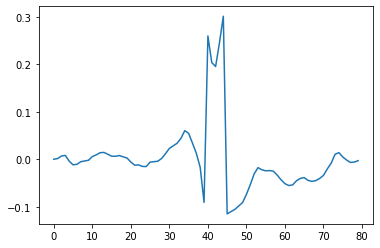

In [79]:
plt.figure()
plt.plot(np.mean(norm_aliased_M.T, axis=0))
plt.show()

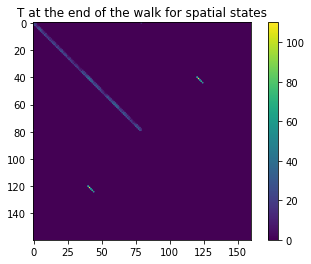

In [14]:
plt.figure()
plt.imshow(T_counts)
plt.title('T at the end of the walk for spatial states')
plt.colorbar()
plt.show()

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_44743/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


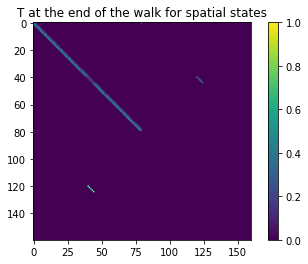

In [15]:
plt.figure()
plt.imshow(normalize(T_counts))
plt.title('T at the end of the walk for spatial states')
plt.colorbar()
plt.show()

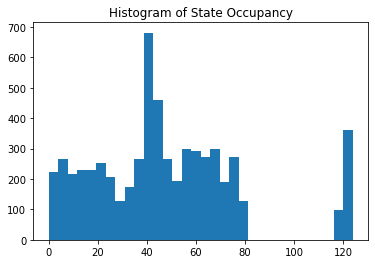

In [16]:
plt.figure()
plt.hist(dataset.expanded_state_inputs, bins=32*dataset.expansion)
plt.title('Histogram of State Occupancy')
plt.show()